[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
Training Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Logistic Regression: {'C': 10.0}
Validation accuracy for Logistic Regression: 0.8238636363636364


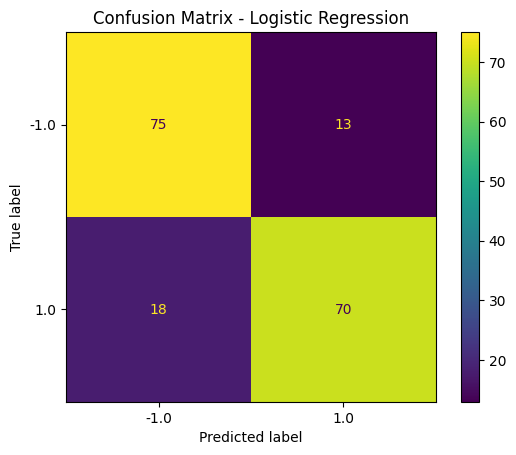

Training MLP Classifier...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for MLP Classifier: {'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 400}
Validation accuracy for MLP Classifier: 0.7840909090909091


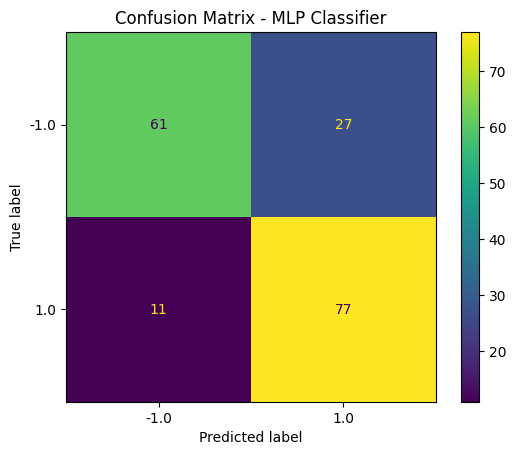

Training SVC...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for SVC: {'C': 10.0, 'kernel': 'rbf'}
Validation accuracy for SVC: 0.8181818181818182


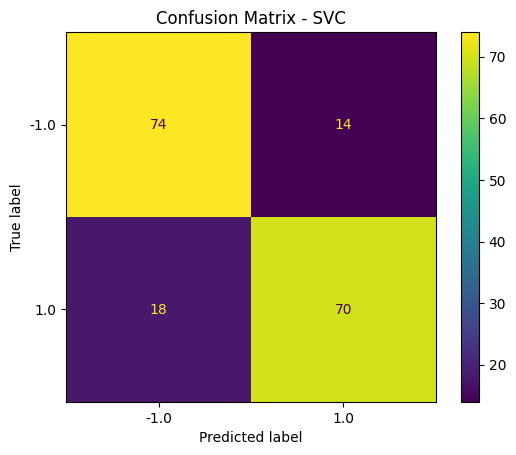

Training AdaBoost Classifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for AdaBoost Classifier: {'learning_rate': 0.1, 'n_estimators': 200}
Validation accuracy for AdaBoost Classifier: 0.7954545454545454


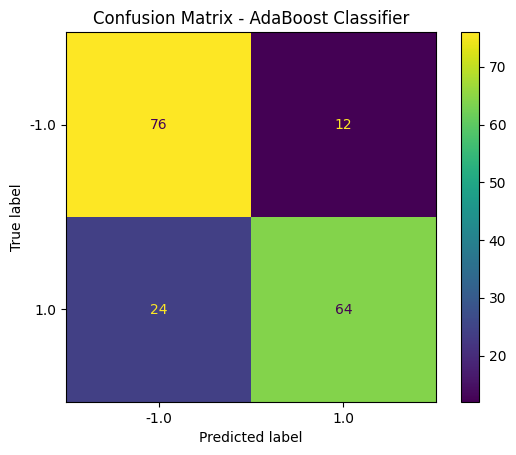

Training Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Validation accuracy for Gradient Boosting: 0.8295454545454546


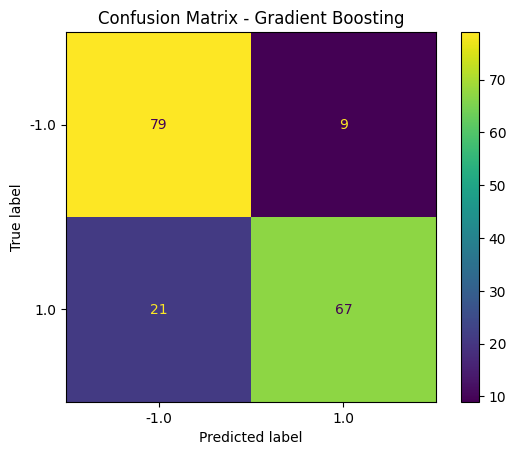

Training KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Validation accuracy for KNN: 0.8125


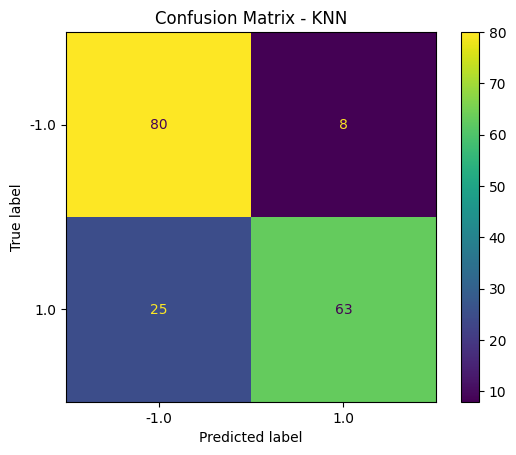

Training Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Validation accuracy for Random Forest: 0.8977272727272727


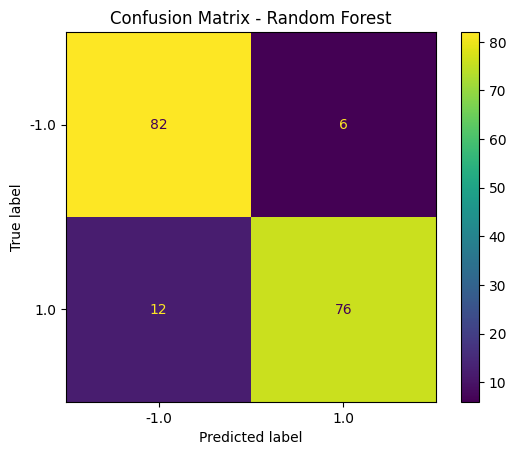

In [3]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from gensim.models import KeyedVectors, Word2Vec
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Load train and test datasets
df_train = pd.read_csv('/content/drive/MyDrive/Projet Intégré S8 (Tweets Réchauffement Climatique)/train_preprocessed.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Projet Intégré S8 (Tweets Réchauffement Climatique)/test_preprocessed.csv')

# Load pretrained Word2Vec model
pretrained_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_frwiki_20180420_100d", filename="frwiki_20180420_100d.txt"))

# Initialize a new Word2Vec model with the same parameters
embedding_dim = pretrained_model.vector_size
new_model = Word2Vec(vector_size=embedding_dim, window=5, min_count=1, sg=1)

# Build the vocabulary for the new model using the training data
sentences = [nltk.word_tokenize(text) for text in df_train['Preprocessed_Tweet']]
new_model.build_vocab(sentences)

# Copy the pretrained embeddings to the new model
for word in new_model.wv.key_to_index:
    if word in pretrained_model:
        new_model.wv[word] = pretrained_model[word]

# Fine-tune the new model on the training data
new_model.train(sentences, total_examples=new_model.corpus_count, epochs=15)

# Function to convert text to Word2Vec embeddings using the fine-tuned model
def word2vec(text):
    vectors = []
    for word in nltk.word_tokenize(text):
        if word in new_model.wv:
            vectors.append(new_model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

# Apply Word2Vec transformation to train and test data
df_train['word2vec'] = df_train['Preprocessed_Tweet'].apply(word2vec)
df_test['word2vec'] = df_test['Preprocessed_Tweet'].apply(word2vec)

# Separate input features (X) and target variable (y)
X = np.stack(df_train['word2vec'].to_numpy())
y = df_train['Polarity']

# Apply oversampling
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_oversampled, y_oversampled = oversample.fit_resample(X, y)

# Split training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42, stratify=y_oversampled)

# Define models and parameter grids for GridSearchCV
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Classifier': MLPClassifier(),
    'SVC': SVC(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0]},
    'MLP Classifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (200, 100, 50)],
        'activation': ['relu', 'tanh'],
        'max_iter': [400, 500],
        'early_stopping': [True]
    },
    'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'AdaBoost Classifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 10]},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
}


# Initialize variables to track the best model
best_of_all_model = None
best_accuracy = 0

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Retrieve the best model from the grid search
    best_model = grid_search.best_estimator_

    # Predict on validation set
    y_val_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy for {model_name}: {accuracy}")

    # Update the best model if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_of_all_model = best_model

    # Display confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [4]:
# Use the best model to make predictions on the test dataset
X_test = np.stack(df_test['word2vec'].to_numpy())
y_test_pred = best_of_all_model.predict(X_test)

# Add predictions to the test dataframe and save to CSV
df_test['Polarity'] = y_test_pred
df_test.to_csv('/content/drive/MyDrive/Projet Intégré S8 (Tweets Réchauffement Climatique)/LabeledTestDataset.csv', index=False)